In [33]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from scipy.stats import mannwhitneyu

In [34]:
data = pd.read_csv('data/mei-lai-wah-bakery/csv/detailed-reviews-of-mei-lai-wah-bakery.csv')

df = data[['place_name', 'rating', 'review_text', 'published_at_date']]
df

,place_name,rating,review_text,published_at_date
0,Mei Lai Wah,5,Best Roast Pork Buns in town! Order dimsun her...,2024-03-28 17:44:46.795169
1,Mei Lai Wah,1,There s a big pc meat bone in the roast pork b...,2024-03-28 17:44:46.804498
2,Mei Lai Wah,5,"Very nice! The buns are soft and full of meat,...",2024-03-28 16:44:46.808813
3,Mei Lai Wah,4,"Great spot to grab cheap, delicious and fulfil...",2024-03-28 16:44:46.813084
4,Mei Lai Wah,4,Very packed and good pineapple buns. The tea w...,2024-03-28 16:44:46.816795
...,...,...,...,...
2135,Mei Lai Wah,5,NaN,2012-03-28 18:50:24.284148
2136,Mei Lai Wah,4,"CHEAP spot to get steamed buns, dim sum and co...",2012-03-28 18:50:24.286351
2137,Mei Lai Wah,4,Ive passed by this place all the time when I w...,2012-03-28 18:50:24.289082
2138,Mei Lai Wah,5,"Originally known as Mei Lai Wah, is now Mei Li...",2012-03-28 18:50:24.291497


Extracting Year from 'published_at_date' column

In [35]:
df['published_at_date'] = pd.to_datetime(df['published_at_date']).dt.year
df

/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_71090/2592446673.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['published_at_date'] = pd.to_datetime(df['published_at_date']).dt.year


,place_name,rating,review_text,published_at_date
0,Mei Lai Wah,5,Best Roast Pork Buns in town! Order dimsun her...,2024
1,Mei Lai Wah,1,There s a big pc meat bone in the roast pork b...,2024
2,Mei Lai Wah,5,"Very nice! The buns are soft and full of meat,...",2024
3,Mei Lai Wah,4,"Great spot to grab cheap, delicious and fulfil...",2024
4,Mei Lai Wah,4,Very packed and good pineapple buns. The tea w...,2024
...,...,...,...,...
2135,Mei Lai Wah,5,NaN,2012
2136,Mei Lai Wah,4,"CHEAP spot to get steamed buns, dim sum and co...",2012
2137,Mei Lai Wah,4,Ive passed by this place all the time when I w...,2012
2138,Mei Lai Wah,5,"Originally known as Mei Lai Wah, is now Mei Li...",2012


Charts for ratings

<Axes: xlabel='rating'>

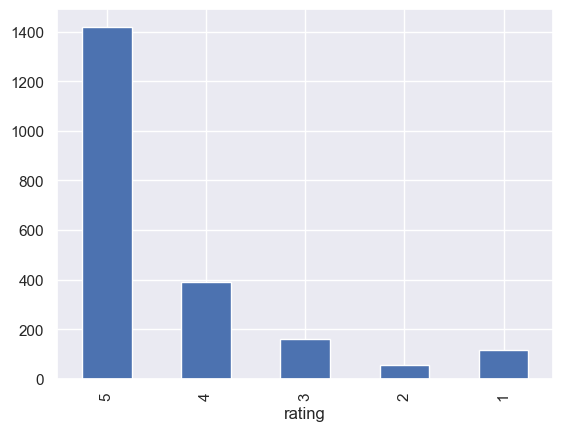

In [36]:
df['rating'].value_counts()[[5, 4, 3, 2, 1]].plot(kind='bar')

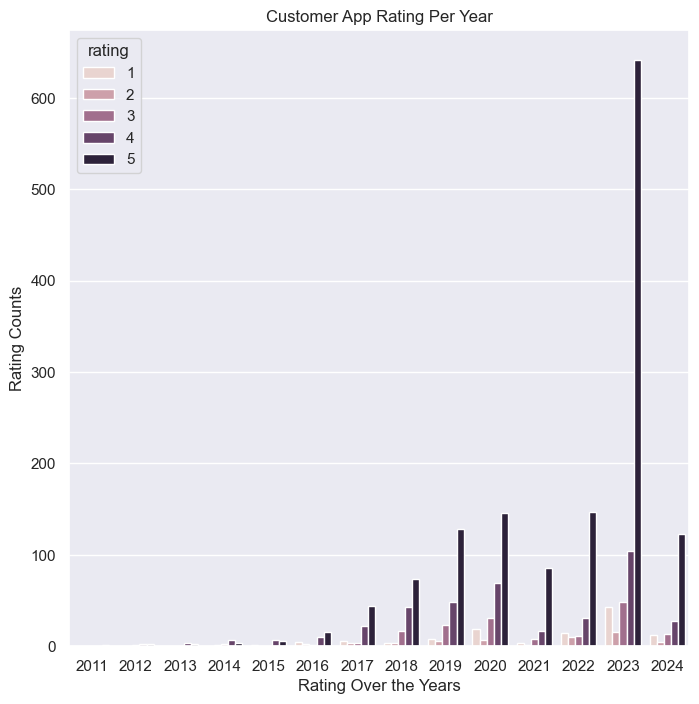

In [37]:
plt.figure(figsize=(8, 8))
sns.countplot(x = 'published_at_date', hue ='rating', data = df)
plt.title('Customer App Rating Per Year')
plt.xlabel("Rating Over the Years")
plt.ylabel('Rating Counts')
plt.show()

In [38]:
df['review_text'] = df['review_text'].astype("string")

df[['review_text']]

/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_71090/2693296585.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_text'] = df['review_text'].astype("string")


,review_text
0,Best Roast Pork Buns in town! Order dimsun her...
1,There s a big pc meat bone in the roast pork b...
2,"Very nice! The buns are soft and full of meat,..."
3,"Great spot to grab cheap, delicious and fulfil..."
4,Very packed and good pineapple buns. The tea w...
...,...
2135,<NA>
2136,"CHEAP spot to get steamed buns, dim sum and co..."
2137,Ive passed by this place all the time when I w...
2138,"Originally known as Mei Lai Wah, is now Mei Li..."


In [39]:
import re
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
stop_words_file = 'Stopwords.txt'

stop_words = []

with open(stop_words_file, "r") as f:
    for line in f:
        stop_words.extend(line.split()) 
        
stop_words = stop_words  

def preprocess(raw_text):
    
    #regular expression keeping only letters 
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convert to lower case and split into words -> convert string into list ( 'hello world' -> ['hello', 'world'])
    words = letters_only_text.lower().split()

    cleaned_words = []
    lemmatizer = PorterStemmer() #plug in here any other stemmer or lemmatiser you want to try out
    
    # remove stopwords
    for word in words:
        if word not in stop_words:
            cleaned_words.append(word)
    
    # stemm or lemmatise words
    stemmed_words = []
    for word in cleaned_words:
        word = lemmatizer.stem(word)   #dont forget to change stem to lemmatize if you are using a lemmatizer
        stemmed_words.append(word)
    
    # converting list back to string
    return " ".join(stemmed_words)

In [40]:
prep = []

for text in df['review_text']:
    if pd.isna(text):
        prep.append('')
    else:
        prep.append(preprocess(text))

df['prep'] = prep

df.head()

/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_71090/1628437642.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prep'] = prep


,place_name,rating,review_text,published_at_date,prep
0,Mei Lai Wah,5,Best Roast Pork Buns in town! Order dimsun her...,2024,roast pork bun town order dimsun
1,Mei Lai Wah,1,There s a big pc meat bone in the roast pork b...,2024,big pc meat bone roast pork bun order crash te...
2,Mei Lai Wah,5,"Very nice! The buns are soft and full of meat,...",2024,nice bun soft full meat meat flavor tender ser...
3,Mei Lai Wah,4,"Great spot to grab cheap, delicious and fulfil...",2024,great spot grab cheap delici fulfil chines foo...
4,Mei Lai Wah,4,Very packed and good pineapple buns. The tea w...,2024,pack good pineappl bun tea nice price reason


In [41]:
from collections import Counter
Counter(" ".join(df["prep"]).split()).most_common(50)

[('bun', 1673),
 ('pork', 1209),
 ('good', 388),
 ('roast', 354),
 ('pineappl', 341),
 ('order', 265),
 ('place', 260),
 ('food', 248),
 ('bake', 247),
 ('delici', 238),
 ('line', 221),
 ('great', 201),
 ('fill', 171),
 ('chinatown', 162),
 ('servic', 157),
 ('steam', 148),
 ('sweet', 145),
 ('price', 129),
 ('time', 125),
 ('cash', 120),
 ('wait', 111),
 ('eat', 107),
 ('meat', 106),
 ('fat', 103),
 ('amaz', 101),
 ('worth', 100),
 ('cheap', 98),
 ('love', 98),
 ('insid', 96),
 ('tast', 95),
 ('long', 93),
 ('back', 91),
 ('recommend', 89),
 ('fresh', 87),
 ('bread', 81),
 ('mei', 80),
 ('wah', 79),
 ('nyc', 78),
 ('bao', 76),
 ('chines', 75),
 ('fast', 74),
 ('rice', 71),
 ('tasti', 71),
 ('roll', 69),
 ('pay', 68),
 ('flavor', 67),
 ('super', 63),
 ('bbq', 62),
 ('peopl', 62),
 ('visit', 62)]

In [42]:
def create_sentiment(rating):
    
    if rating==1 or rating==2:
        return -1 # negative sentiment
    elif rating==4 or rating==5:
        return 1 # positive sentiment
    else:
        return 0 # neutral sentiment

df['sentiment'] = df['rating'].apply(create_sentiment)
df

/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_71090/1400198503.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['rating'].apply(create_sentiment)


,place_name,rating,review_text,published_at_date,prep,sentiment
0,Mei Lai Wah,5,Best Roast Pork Buns in town! Order dimsun her...,2024,roast pork bun town order dimsun,1
1,Mei Lai Wah,1,There s a big pc meat bone in the roast pork b...,2024,big pc meat bone roast pork bun order crash te...,-1
2,Mei Lai Wah,5,"Very nice! The buns are soft and full of meat,...",2024,nice bun soft full meat meat flavor tender ser...,1
3,Mei Lai Wah,4,"Great spot to grab cheap, delicious and fulfil...",2024,great spot grab cheap delici fulfil chines foo...,1
4,Mei Lai Wah,4,Very packed and good pineapple buns. The tea w...,2024,pack good pineappl bun tea nice price reason,1
...,...,...,...,...,...,...
2135,Mei Lai Wah,5,<NA>,2012,,1
2136,Mei Lai Wah,4,"CHEAP spot to get steamed buns, dim sum and co...",2012,cheap spot steam bun dim sum conge love standa...,1
2137,Mei Lai Wah,4,Ive passed by this place all the time when I w...,2012,ive pass place time younger knew miss friend i...,1
2138,Mei Lai Wah,5,"Originally known as Mei Lai Wah, is now Mei Li...",2012,origin mei lai wah mei li wah rare find antiqu...,1


<Axes: xlabel='sentiment', ylabel='count'>

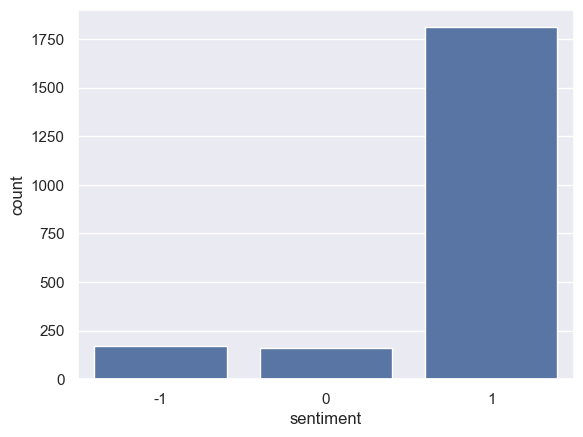

In [43]:
sns.set_theme()

# Create a visualization
sns.countplot(
    data=df,
    x="sentiment"
)

In [44]:
# initialize NLTK sentiment analyzer

analyzer = SentimentIntensityAnalyzer()


# create get_sentiment function

def get_sentiment(text):

    scores = analyzer.polarity_scores(text)

    sentiment = 1 if scores['pos'] > 0 else 0

    return scores['compound']




# apply get_sentiment function

df['review_sentiment'] = df['prep'].apply(get_sentiment)

df['review_sentiment']

/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_71090/3818571148.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_sentiment'] = df['prep'].apply(get_sentiment)


0       0.0000
1      -0.4767
2       0.6249
3       0.9607
4       0.6908
         ...  
2135    0.0000
2136    0.2732
2137    0.6808
2138    0.9153
2139    0.0000
Name: review_sentiment, Length: 2140, dtype: float64

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents=None, 
                        lowercase=False,
                        preprocessor=None)

X = tfidf.fit_transform(df['prep'])

years = df['published_at_date']

from sklearn.model_selection import train_test_split
y = df['sentiment'] # target variable
X_train, X_test, y_train, y_test, years_train, years_test = train_test_split(X,y, years)

In [46]:
# SVM
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

clf = LinearSVC(random_state=0)

clf.fit(X_train,y_train)

y_test_pred=clf.predict(X_test)

report=classification_report(y_test, y_test_pred, output_dict=True)
report

/Users/aimeeoh/Desktop/Documents/Columbia/EDS/FinalProject/FoodResearch/.venv/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


{'-1': {'precision': 0.7894736842105263,
  'recall': 0.3191489361702128,
  'f1-score': 0.45454545454545453,
  'support': 47.0},
 '0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 27.0},
 '1': {'precision': 0.887378640776699,
  'recall': 0.9913232104121475,
  'f1-score': 0.9364754098360656,
  'support': 461.0},
 'accuracy': 0.8822429906542056,
 'macro avg': {'precision': 0.5589507749957418,
  'recall': 0.4368240488607868,
  'f1-score': 0.46367362146050667,
  'support': 535.0},
 'weighted avg': {'precision': 0.8339940496372953,
  'recall': 0.8822429906542056,
  'f1-score': 0.8468762622393694,
  'support': 535.0}}

In [47]:
from sklearn.metrics import accuracy_score
from scipy.stats import chi2_contingency

predictions_df = pd.DataFrame({'Sentiment': y_test_pred, 'Years': years_test})

# Create a contingency table
contingency_table = pd.crosstab(predictions_df['Sentiment'], predictions_df['Years'])

# Perform chi-square test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

# Output results
print("Chi-square statistic:", chi2_stat)
print("Degrees of freedom:", dof)
print("p-value:", p_val)
print("Expected frequencies:\n", expected)
print("Contingency table:\n", contingency_table)

Chi-square statistic: 18.464620240009804
Degrees of freedom: 24
p-value: 0.7799059470399851
Expected frequencies:
 [[7.10280374e-02 7.10280374e-02 1.42056075e-01 2.48598131e-01
  3.19626168e-01 7.10280374e-01 1.34953271e+00 1.52710280e+00
  2.23738318e+00 9.23364486e-01 1.77570093e+00 7.56448598e+00
  2.05981308e+00]
 [3.73831776e-03 3.73831776e-03 7.47663551e-03 1.30841121e-02
  1.68224299e-02 3.73831776e-02 7.10280374e-02 8.03738318e-02
  1.17757009e-01 4.85981308e-02 9.34579439e-02 3.98130841e-01
  1.08411215e-01]
 [1.92523364e+00 1.92523364e+00 3.85046729e+00 6.73831776e+00
  8.66355140e+00 1.92523364e+01 3.65794393e+01 4.13925234e+01
  6.06448598e+01 2.50280374e+01 4.81308411e+01 2.05037383e+02
  5.58317757e+01]]
Contingency table:
 Years      2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  \
Sentiment                                                                     
-1            0     0     0     0     0     0     1     1     1     1     2   
 0            0

In [48]:
# Wilcoxon rank-sum / Mann-whitney U Test
year = 2020

before_data = df[df['published_at_date'] < year]
after_data = df[df['published_at_date'] >= year]

u_stat, p_value_mw = mannwhitneyu(before_data['review_sentiment'], after_data['review_sentiment'])
print("Mann-Whitney U test - U-statistic:", u_stat, "p-value:", p_value_mw)

Mann-Whitney U test - U-statistic: 409095.5 p-value: 0.7002852010407489


In [49]:
# make altered data into csv file
df.to_csv('altdata/' + 'meilaiwah.csv', index=False)